## Assignment_Decision_Tree_Fraud_Check

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

C:\Users\PRASAD\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Import Dataset
df = pd.read_csv('Fraud_check.csv')
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


#### Data Exploration

In [3]:
#checking missing values if any
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [4]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [5]:
df.shape

(600, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [7]:
df[df.duplicated()].shape

(0, 6)

In [8]:
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [9]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


#### Feature Engineering

In [10]:
#Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


#### Data Visualization

<Figure size 576x576 with 0 Axes>

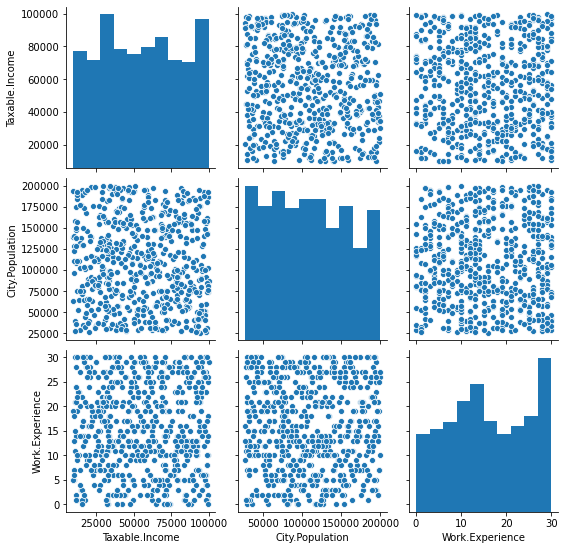

In [11]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

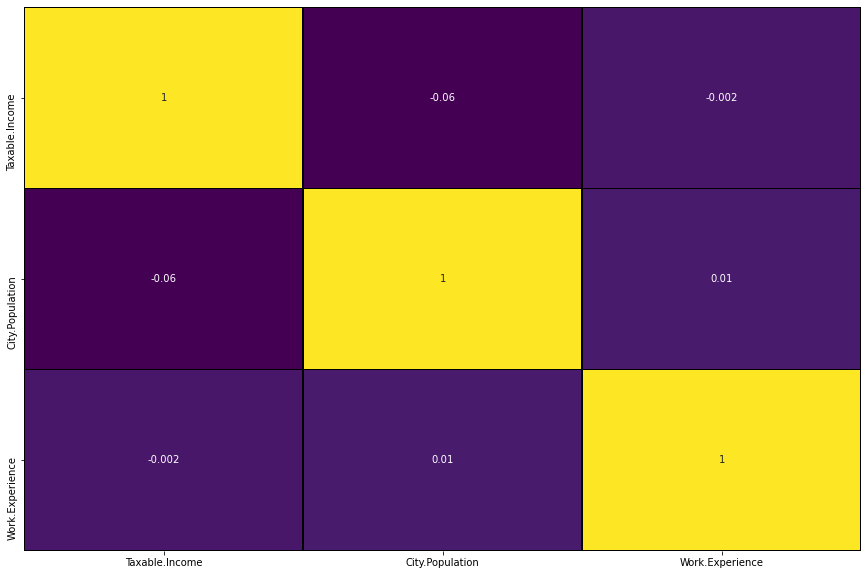

In [12]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

In [13]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [14]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [15]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [16]:
data.taxable_category.value_counts()

0    476
1    124
Name: taxable_category, dtype: int64

## Test Train Split With Imbalanced Dataset

In [17]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split

x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [18]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [19]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### Building Decision Tree Classifier using Entropy Criteria with Alpha values Post Pruning¶

In [20]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

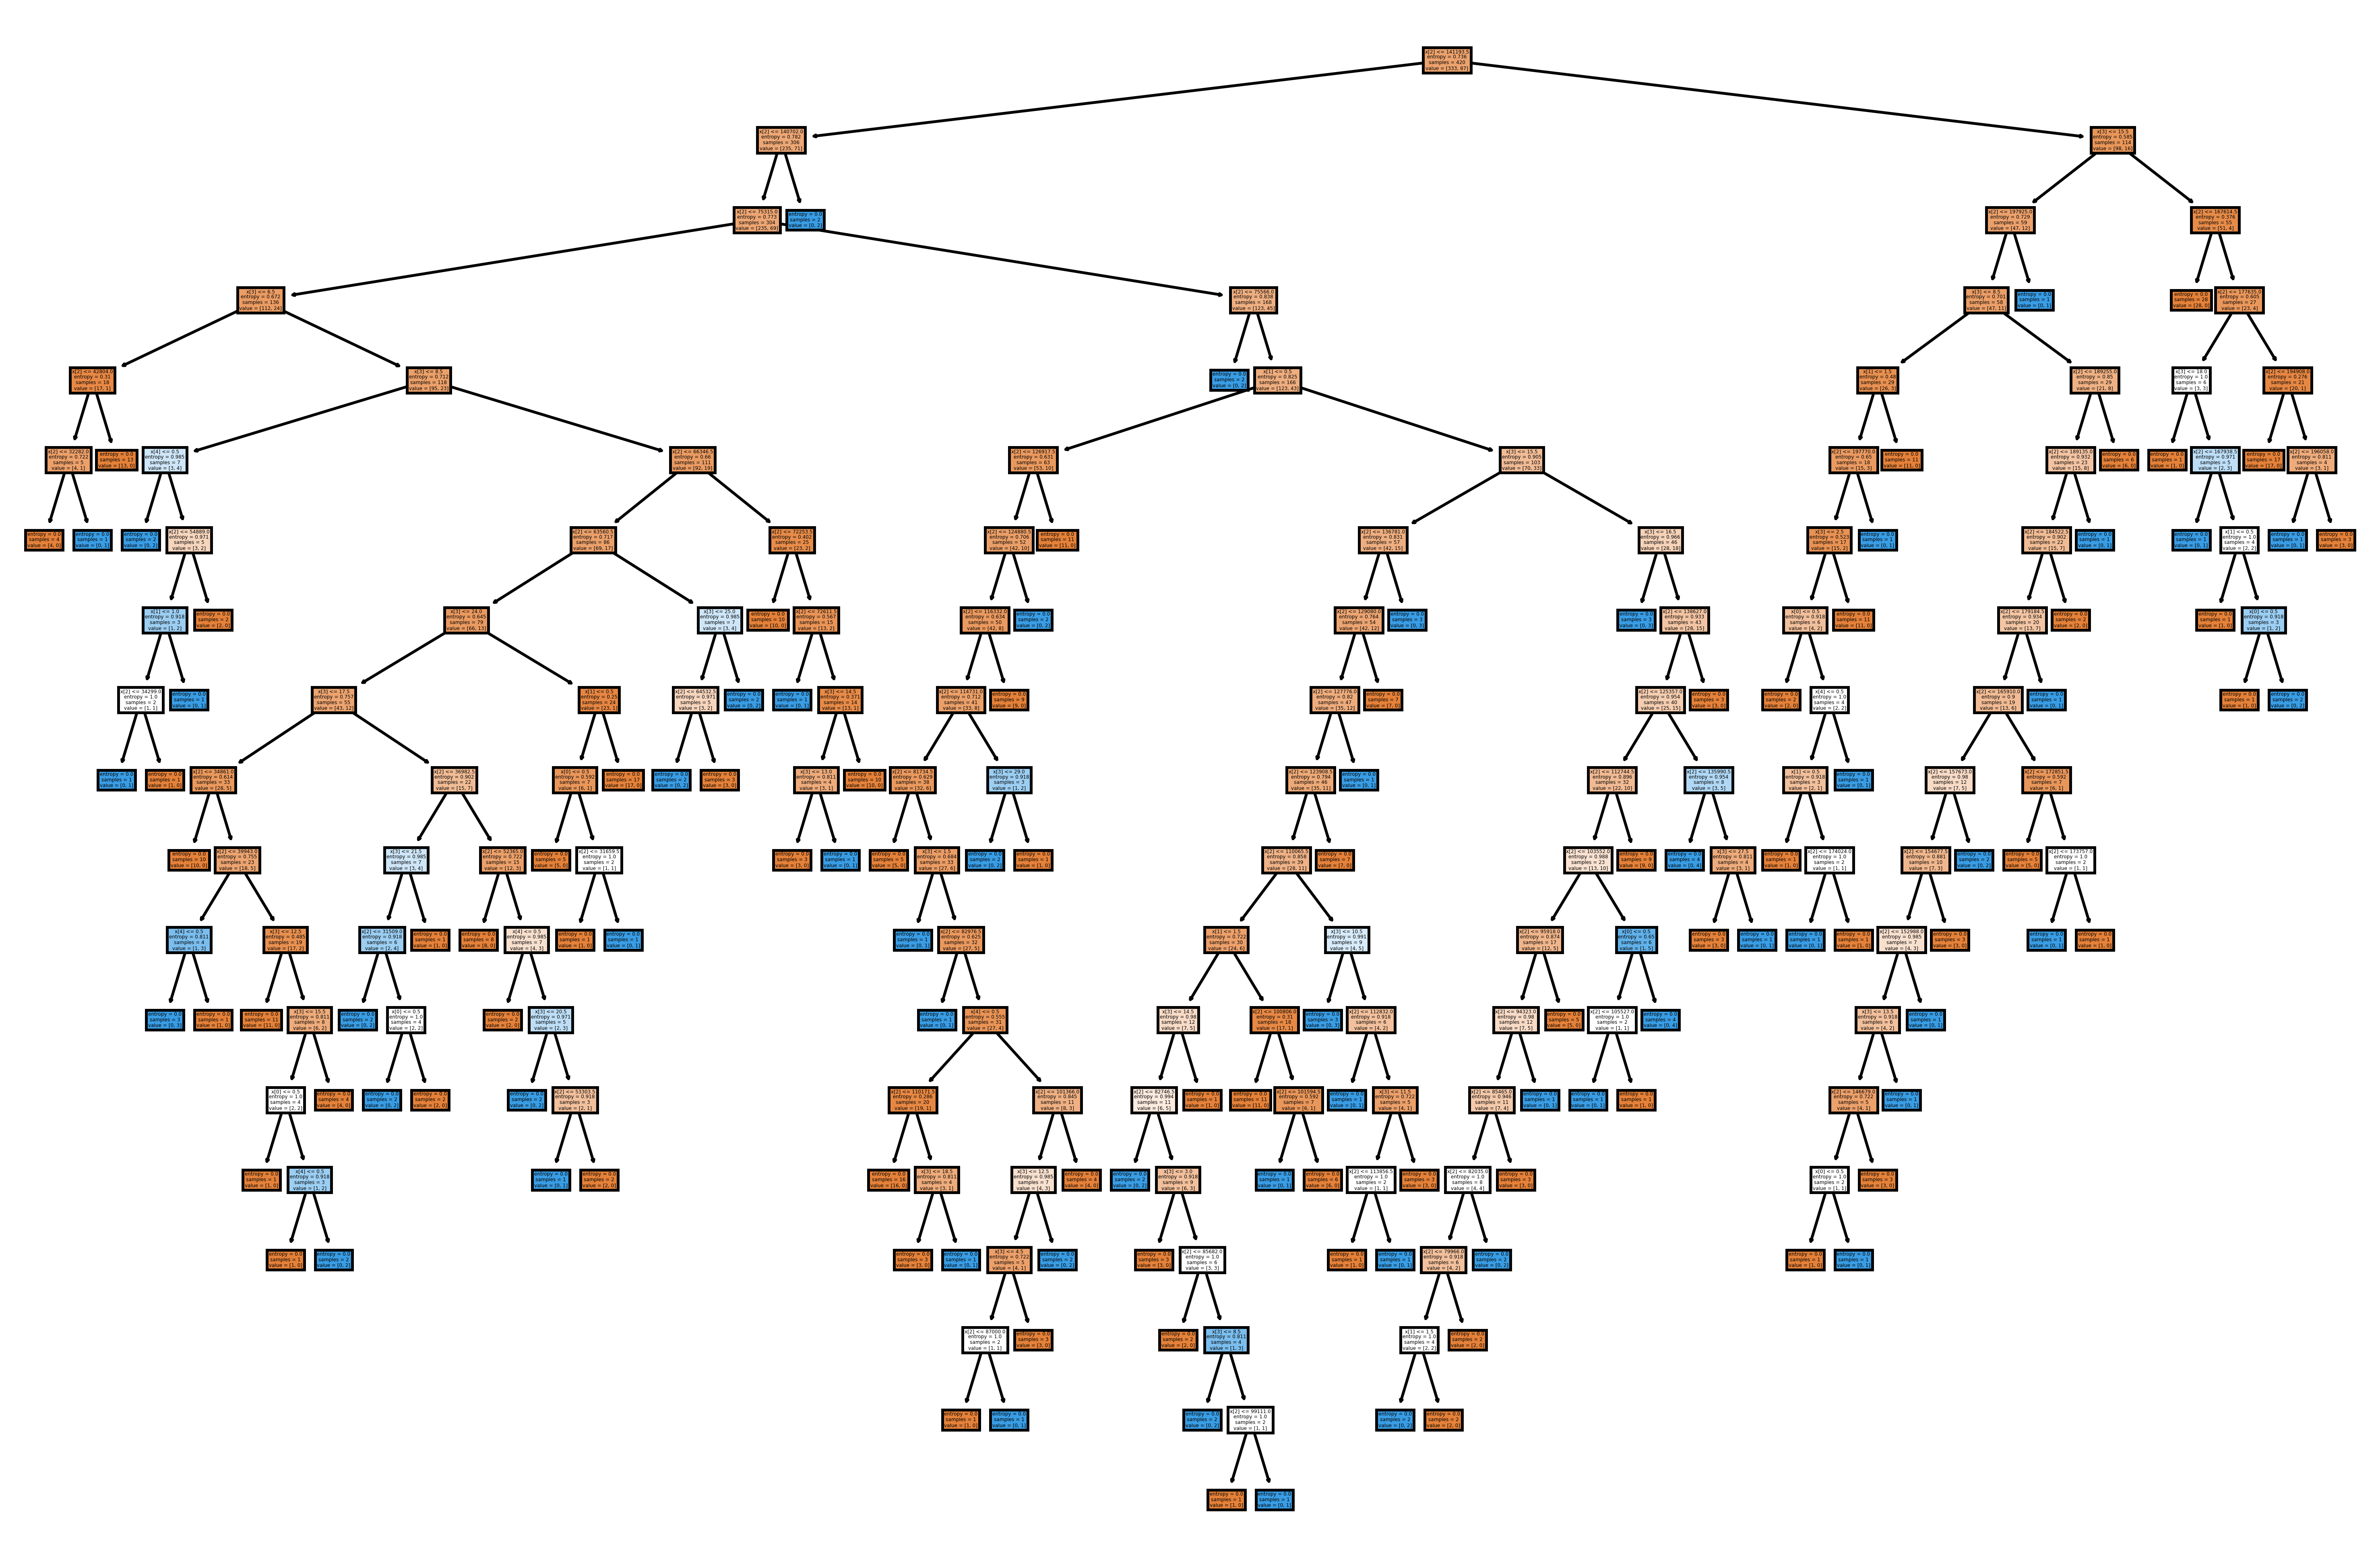

In [21]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [22]:
#Predicting on test data
preds = model_entropy.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    123
1     57
dtype: int64

In [23]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0,0,1
taxable_category,,
0,98,45
1,25,12


In [24]:
# Accuracy 
np.mean(preds==y_test)

0.6111111111111112

In [25]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       143
           1       0.21      0.32      0.26        37

    accuracy                           0.61       180
   macro avg       0.50      0.50      0.50       180
weighted avg       0.68      0.61      0.64       180



In [26]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [27]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.009249011935413321


In [28]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=0.00983548)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00983548, criterion='entropy',
                       random_state=0)

In [29]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7928571428571428 
Testing Accuracy 0.7944444444444444


              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



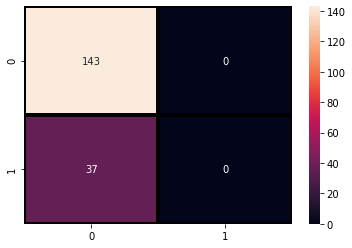

In [30]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

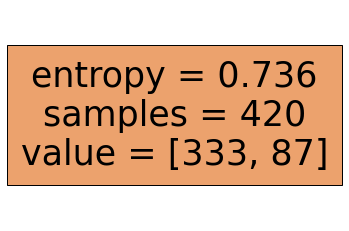

In [31]:
plt.figure(figsize=(6,4))
tree.plot_tree(clf,filled=True)
plt.show()

### Building Decision Tree Classifier using Gini Criteria with Alpha values Post Pruning

In [32]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

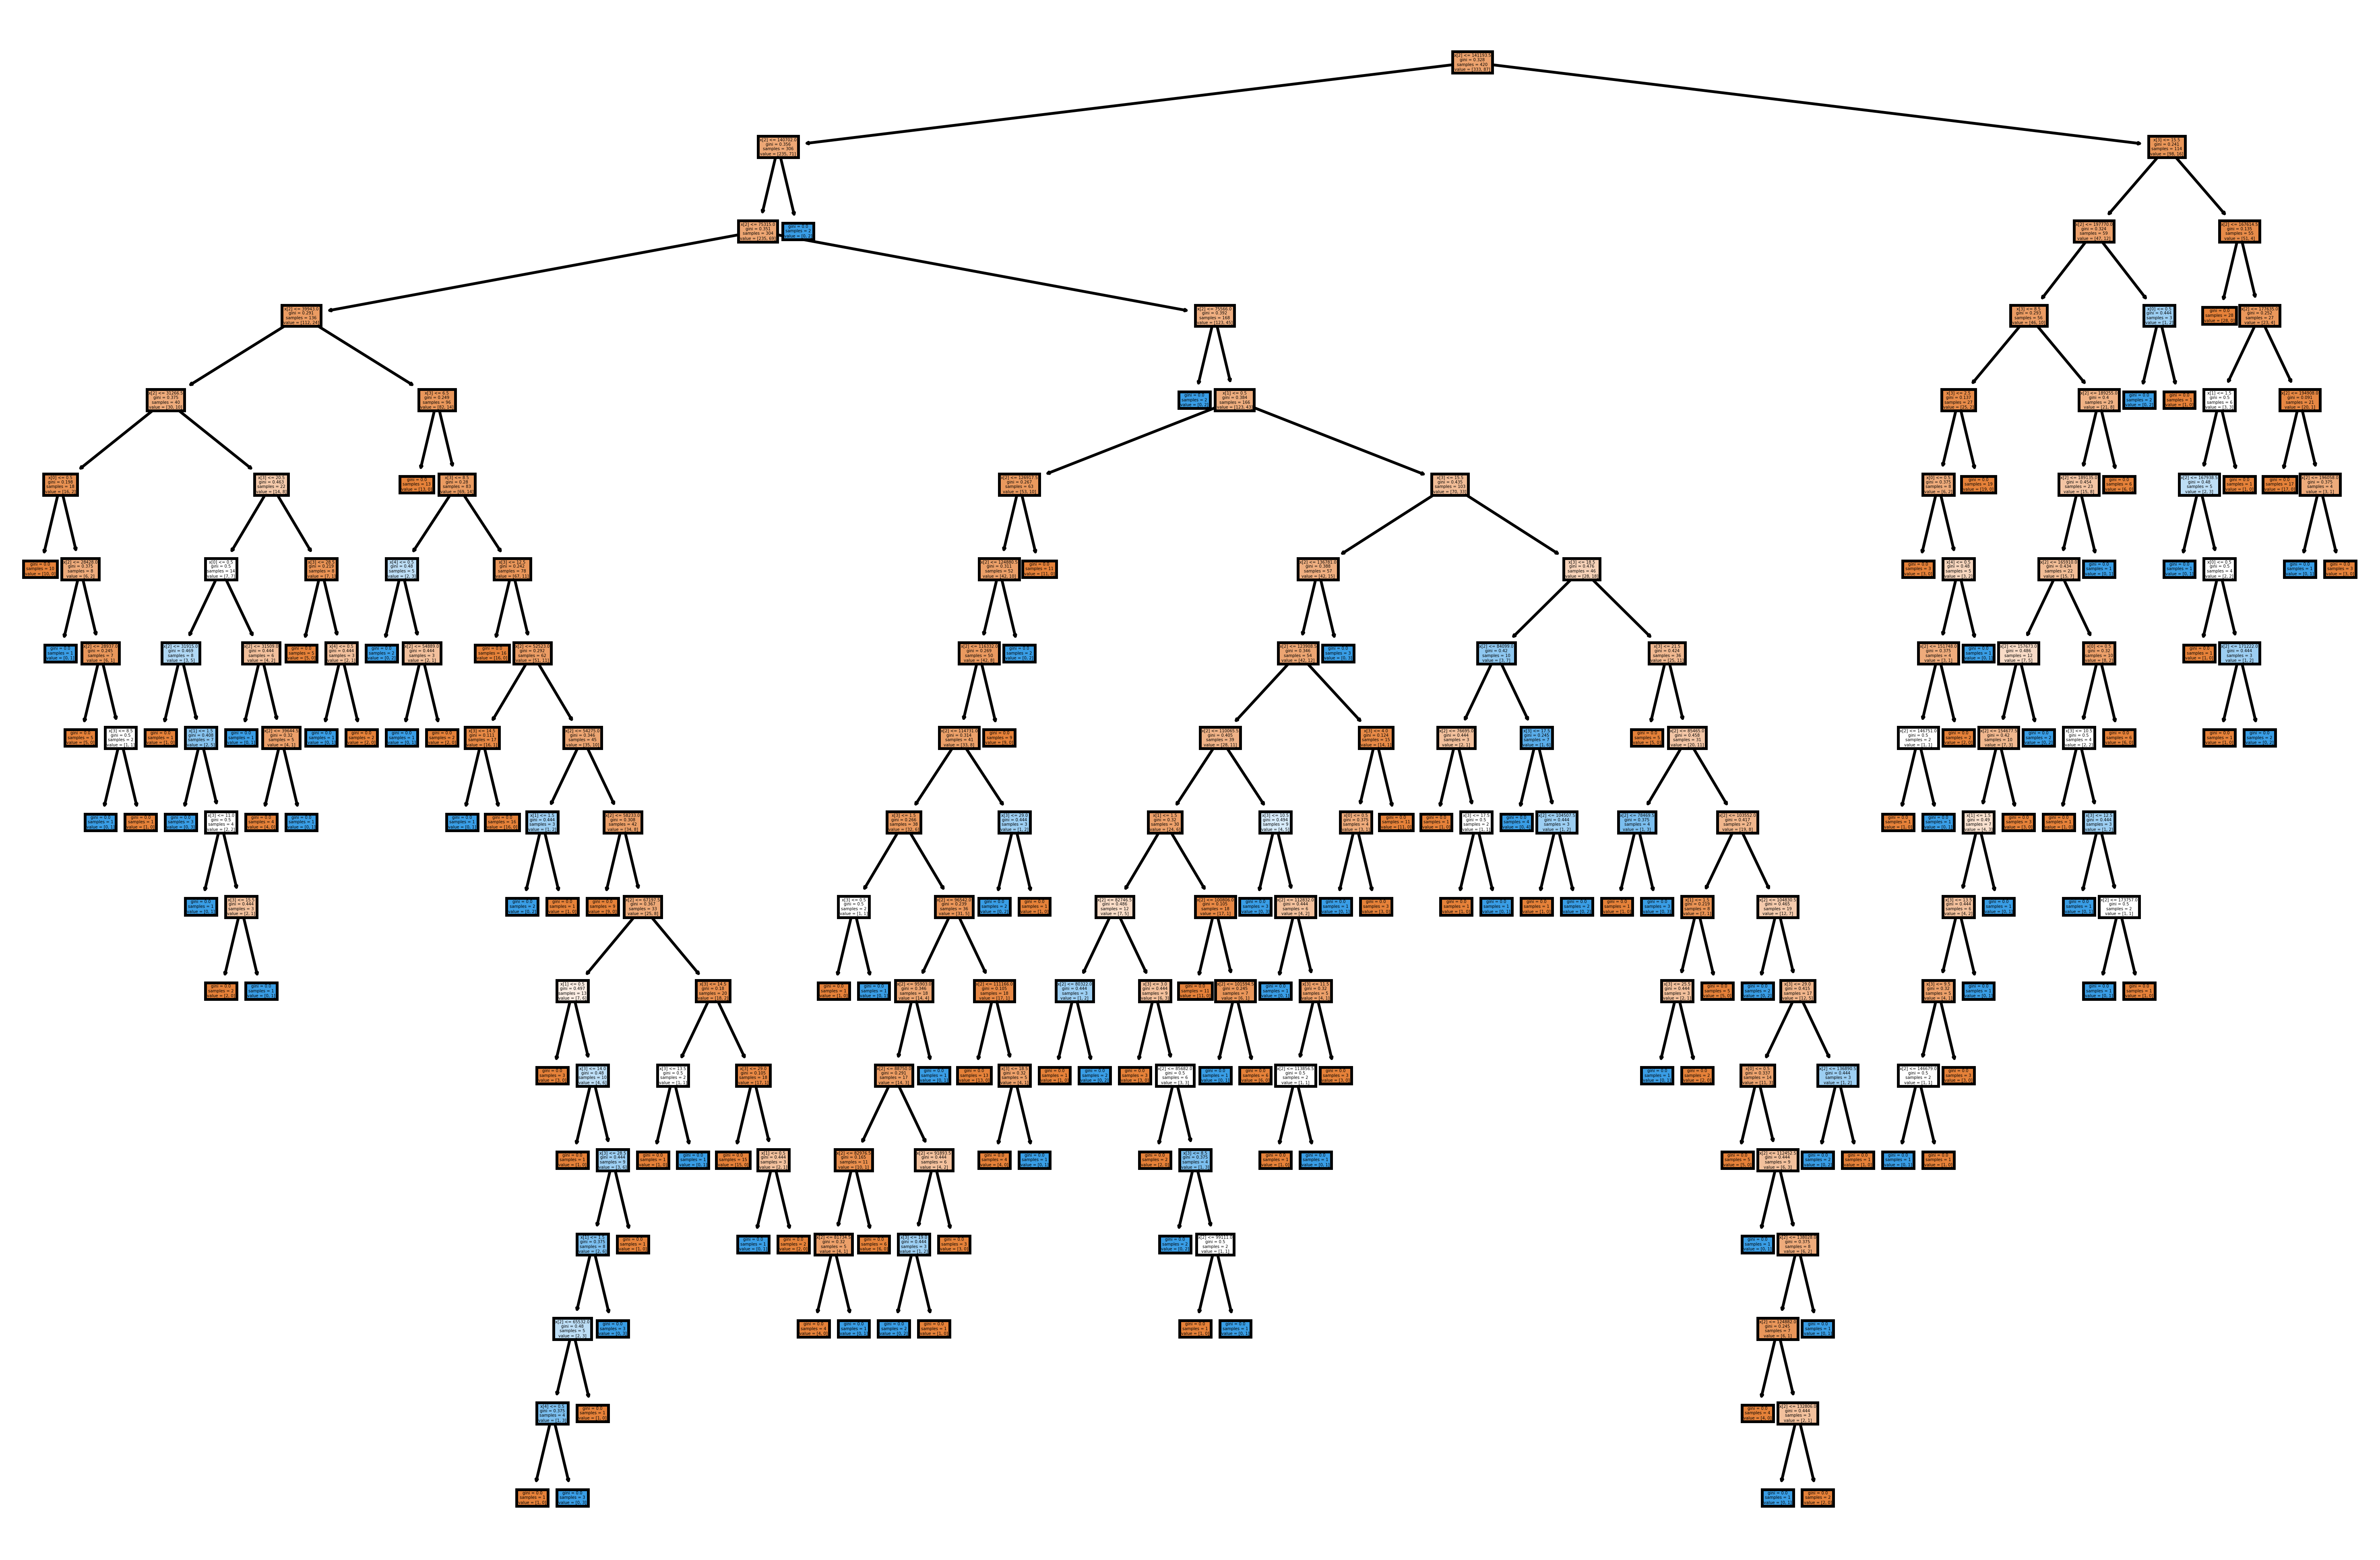

In [33]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_gini,filled=True)
plt.show()

In [34]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

0    133
1     47
dtype: int64

In [35]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0,0,1
taxable_category,,
0,105,38
1,28,9


In [36]:
# Accuracy 
np.mean(preds==y_test)

0.6333333333333333

In [37]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       143
           1       0.19      0.24      0.21        37

    accuracy                           0.63       180
   macro avg       0.49      0.49      0.49       180
weighted avg       0.67      0.63      0.65       180



In [38]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [39]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.004746761277610458


In [40]:
clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=0.00600582)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00600582, random_state=0)

In [41]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7928571428571428 
Testing Accuracy 0.7944444444444444


              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



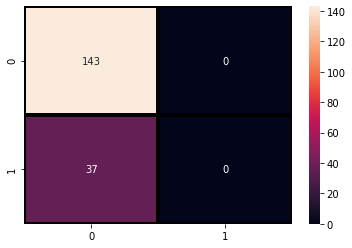

In [42]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

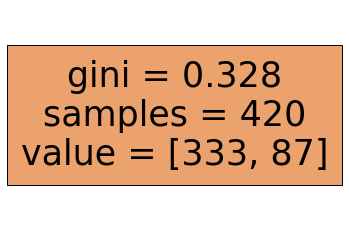

In [43]:
plt.figure(figsize=(6,4))
tree.plot_tree(clf,filled=True)
plt.show()